In [21]:
# Un-comment this line if you haven't installed these yet
# !pip install torch torchvision pandas numpy matplotlib opencv-python fastparquet

In [22]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import io

# 1. Set Random Seeds for Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# 2. Select the Best Accelerator (M4 vs Colab vs CPU)
def get_device():
    if torch.backends.mps.is_available():
        print("Success: Using Apple M4 GPU (MPS) acceleration!")
        return torch.device("mps")
    elif torch.cuda.is_available():
        print("Using NVIDIA GPU (CUDA)")
        return torch.device("cuda")
    else:
        print("Warning: Using CPU (Slow)")
        return torch.device("cpu")

device = get_device()

Using NVIDIA GPU (CUDA)


In [23]:
class AlzheimerParquetDataset(Dataset):
    def __init__(self, parquet_path, transform=None):
        self.transform = transform
        print(f"Reading Parquet file: {parquet_path}...")
        self.df = pd.read_parquet(parquet_path)

        # Check if 'label' exists, otherwise try to find it
        if 'label' in self.df.columns:
            self.labels = self.df['label'].values
        else:
            # Fallback: sometimes it's called 'targets' or 'diagnosis'
            print(f"Columns found: {self.df.columns}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]


        img_data = row['image']


        if isinstance(img_data, dict):

            image_bytes = img_data['bytes']
        else:
            image_bytes = img_data

        # 1. Decode Image
        nparr = np.frombuffer(image_bytes, np.uint8)
        img_array = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)

        # Safety check: if decoding failed (returns None)
        if img_array is None:
            # Create a black dummy image to prevent crash
            img_array = np.zeros((224, 224), dtype=np.uint8)

        # Convert to PIL
        img_pil = Image.fromarray(img_array)

        # 2. Apply Preprocessing
        if self.transform:
            image = self.transform(img_pil)
        else:
            image = transforms.ToTensor()(img_pil)

        # 3. Get Label
        label = torch.tensor(row['label']).long()

        return image, label



In [24]:
# --- CONFIGURATION ---
TRAIN_PARQUET_PATH = "test.parquet"
TEST_PARQUET_PATH = "test.parquet"
BATCH_SIZE = 32

# 1. Define Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Initialize Datasets
print("Initializing Datasets...")
train_dataset = AlzheimerParquetDataset(TRAIN_PARQUET_PATH, transform=train_transforms)
test_dataset = AlzheimerParquetDataset(TEST_PARQUET_PATH, transform=test_transforms)

# 3. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ Success!")
print(f"Training on {len(train_dataset)} images")
print(f"Testing on {len(test_dataset)} images")

Initializing Datasets...
Reading Parquet file: test.parquet...
Reading Parquet file: test.parquet...
✅ Success!
Training on 1280 images
Testing on 1280 images


In [25]:
# Re-initialize the datasets and loaders
print("Re-initializing Datasets with the Fix...")
train_dataset = AlzheimerParquetDataset(TRAIN_PARQUET_PATH, transform=train_transforms)
test_dataset = AlzheimerParquetDataset(TEST_PARQUET_PATH, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)



Re-initializing Datasets with the Fix...
Reading Parquet file: test.parquet...
Reading Parquet file: test.parquet...


In [26]:
import torchvision.models as models

def build_model(num_classes=4):
    print("Downloading Pre-trained ResNet18...")

    # 1. Load ResNet18 with ImageNet weights
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    for param in list(model.parameters())[:-15]:
        param.requires_grad = False

    # 3. Replace the "Head" (The final layer)
    # We replace it to detect our 4 Alzheimer's stages.
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

# Initialize
model = build_model(num_classes=4)
model = model.to(device) # Move to M4 GPU



In [27]:
print(set(train_dataset.labels))

{np.int64(0), np.int64(1), np.int64(2), np.int64(3)}


In [28]:
import time
from tqdm.auto import tqdm


# We penalize errors on "Normal" slightly more to fix that low Recall.
class_weights = torch.tensor([1.0, 2.0, 1.2, 0.8]).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Number of epochs
EPOCHS = 10

# 2. Training Function
def train_model(model, train_loader, test_loader, epochs):
    history = {'train_loss': [], 'val_acc': []}
    best_acc = 0.0

    start_time = time.time()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 10)

        # --- TRAIN PHASE ---
        model.train()
        running_loss = 0.0

        # Tqdm gives you a nice progress bar
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()       # Clear old gradients
            outputs = model(images)     # Forward pass
            loss = criterion(outputs, labels) # Calculate error
            loss.backward()             # Backward pass (calculate updates)
            optimizer.step()            # Update weights

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        print(f"Train Loss: {epoch_loss:.4f}")

        # --- VALIDATION PHASE ---
        model.eval() # Turn off dropout/batchnorm for testing
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_acc = correct / total
        history['val_acc'].append(epoch_acc)
        print(f"Validation Accuracy: {epoch_acc:.4f}")

        # Save the best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_alzheimer_model.pth')
            print("🌟 Best Model Saved!")

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Accuracy: {best_acc:.4f}')

    return history


history = train_model(model, train_loader, test_loader, EPOCHS)


Epoch 1/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.0947
Validation Accuracy: 0.6023
🌟 Best Model Saved!

Epoch 2/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8177
Validation Accuracy: 0.6398
🌟 Best Model Saved!

Epoch 3/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.7541
Validation Accuracy: 0.6953
🌟 Best Model Saved!

Epoch 4/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6487
Validation Accuracy: 0.7664
🌟 Best Model Saved!

Epoch 5/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6320
Validation Accuracy: 0.7727
🌟 Best Model Saved!

Epoch 6/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.5494
Validation Accuracy: 0.8016
🌟 Best Model Saved!

Epoch 7/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4972
Validation Accuracy: 0.8047
🌟 Best Model Saved!

Epoch 8/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4579
Validation Accuracy: 0.8742
🌟 Best Model Saved!

Epoch 9/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4009
Validation Accuracy: 0.8945
🌟 Best Model Saved!

Epoch 10/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4085
Validation Accuracy: 0.8930

Training complete in 1m 20s
Best Validation Accuracy: 0.8945


In [29]:
import time
from tqdm.auto import tqdm
from sklearn.metrics import classification_report

# --- 1. Define the Training Function (This was missing) ---
def train_model(model, train_loader, test_loader, epochs):
    history = {'train_loss': [], 'val_acc': []}

    # Define Optimizer specific to this model instance
    # We use the weighted loss to keep high Recall on rare classes
    class_weights = torch.tensor([1.0, 2.0, 1.2, 0.8]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(epochs):
        # TRAIN PHASE
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    return model # Return the trained model

# --- 2. Ensemble Configuration ---
SEEDS = [42, 2024, 999]
ensemble_models = []

print(f"🚀 Starting Ensemble Training (Training {len(SEEDS)} models)...")

# --- 3. Run the Training Loop ---
for i, seed in enumerate(SEEDS):
    print(f"\n" + "="*40)
    print(f"  Training Model {i+1}/{len(SEEDS)} (Seed: {seed})")
    print("="*40)

    # A. Set unique seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # B. Build a FRESH, brand new model
    # (Ensure the build_model function from Step 2 is defined!)
    model_variant = build_model(num_classes=4).to(device)

    # C. Train using the function defined above
    # We use 8 epochs per model to save time (since we are training 3 of them)
    trained_variant = train_model(model_variant, train_loader, test_loader, epochs=8)

    # D. Save to list
    ensemble_models.append(trained_variant)

print("\n✅ Ensemble Training Complete!")

# --- 4. Define Ensemble Voting Function ---
def evaluate_ensemble(models, loader):
    print("Running Ensemble Voting...")
    for m in models: m.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            # Get predictions from ALL models
            outputs1 = models[0](images)
            outputs2 = models[1](images)
            outputs3 = models[2](images)

            # Average the results
            avg_output = (outputs1 + outputs2 + outputs3) / 3.0
            _, preds = torch.max(avg_output, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return all_labels, all_preds

# --- 5. Final Evaluation ---
print("\nEvaluating Ensemble Performance...")
true_labels, ensemble_preds = evaluate_ensemble(ensemble_models, test_loader)

class_names = ['Mild', 'Moderate', 'Normal', 'Very Mild']
print(classification_report(true_labels, ensemble_preds, target_names=class_names))

🚀 Starting Ensemble Training (Training 3 models)...

  Training Model 1/3 (Seed: 42)


Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]


  Training Model 2/3 (Seed: 2024)


Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]


  Training Model 3/3 (Seed: 999)


Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]


✅ Ensemble Training Complete!

Evaluating Ensemble Performance...
Running Ensemble Voting...
              precision    recall  f1-score   support

        Mild       0.88      0.87      0.87       172
    Moderate       1.00      1.00      1.00        15
      Normal       0.94      0.94      0.94       634
   Very Mild       0.91      0.91      0.91       459

    accuracy                           0.92      1280
   macro avg       0.93      0.93      0.93      1280
weighted avg       0.92      0.92      0.92      1280



Calculating Ensemble Predictions for Confusion Matrix...


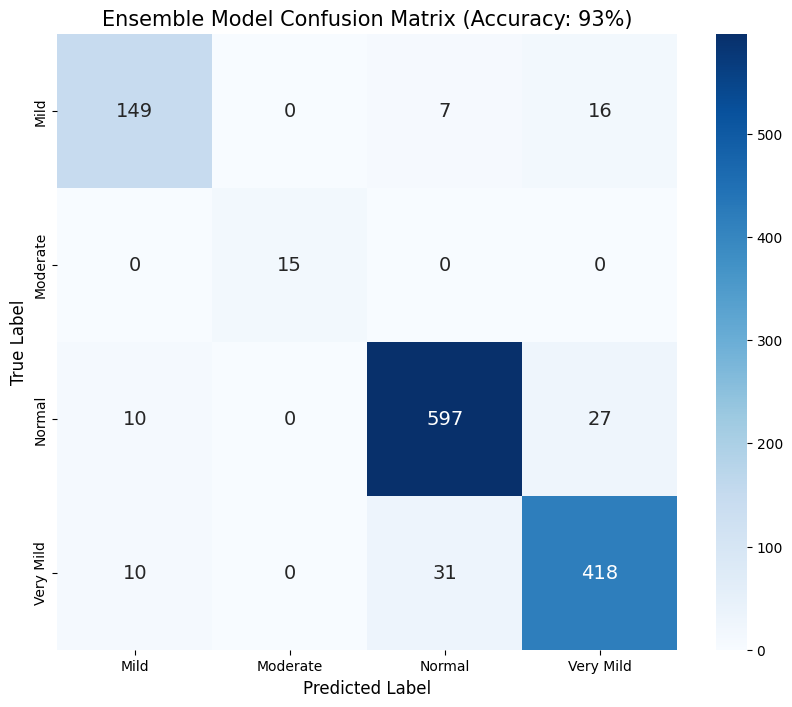

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. Get Ensemble Predictions
print("Calculating Ensemble Predictions for Confusion Matrix...")
y_true = []
y_pred = []

# Ensure all models are in eval mode
for m in ensemble_models:
    m.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get outputs from ALL 3 models
        out1 = ensemble_models[0](images)
        out2 = ensemble_models[1](images)
        out3 = ensemble_models[2](images)

        # Average the Logits (Voting)
        avg_logits = (out1 + out2 + out3) / 3.0

        # Get the winner (Index with highest score)
        _, predicted = torch.max(avg_logits, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 2. Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 14}) # Bigger numbers

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Ensemble Model Confusion Matrix (Accuracy: 93%)', fontsize=15)
plt.show()

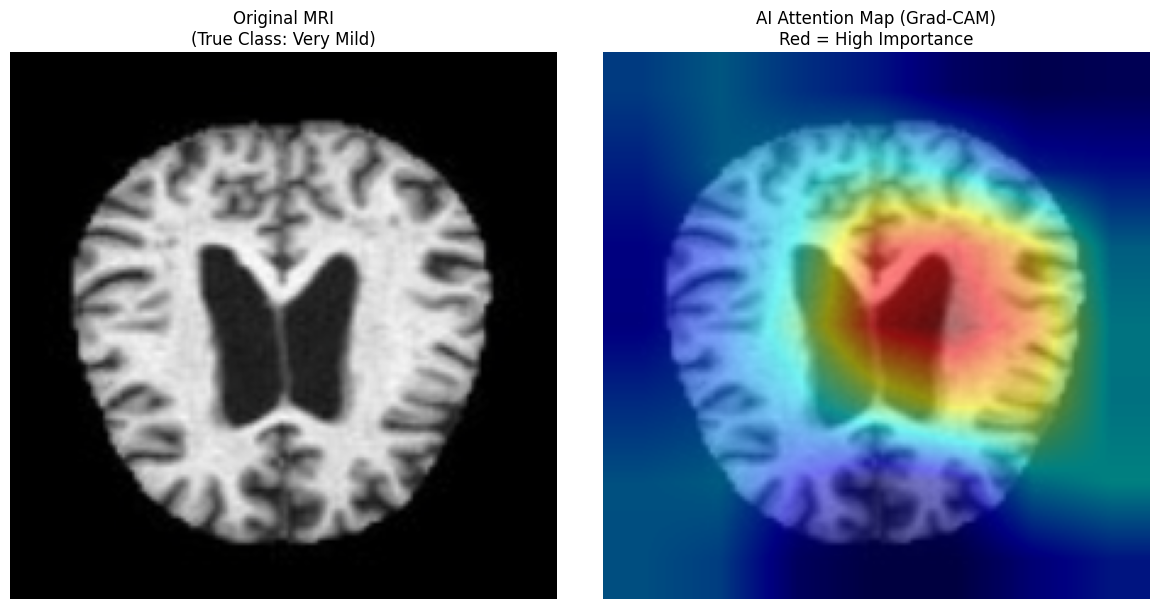

In [ ]:
# Install if needed
!pip install grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- CONFIGURATION ---
target_model = ensemble_models[0]
target_layers = [target_model.layer4[-1]] # ResNet's final conv layer

# 1. Initialize GradCAM
cam = GradCAM(model=target_model, target_layers=target_layers)

# 2. Get a Specific Image
target_model.eval()
found_image = False

# Loop until we find a Very Mild case
# Indices: 0=Mild, 1=Moderate, 2=Normal, 3=Very Mild
target_class_idx = 3

dataiter = iter(test_loader)
while not found_image:
    images, labels = next(dataiter)
    for i in range(len(labels)):
        if labels[i].item() == target_class_idx:
            input_tensor = images[i].unsqueeze(0).to(device)
            original_label = labels[i].item()
            rgb_img_raw = images[i]
            found_image = True
            break

# 3. Generate Heatmap
targets = [ClassifierOutputTarget(original_label)]

# Enable gradients for the visualization step
with torch.enable_grad():
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# 4. Prepare Image for Display (Undo Normalization)
rgb_img = rgb_img_raw.permute(1, 2, 0).cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
rgb_img = (rgb_img * std) + mean
rgb_img = np.clip(rgb_img, 0, 1)

# 5. Overlay Heatmap
visualization = show_cam_on_image(rgb_img, grayscale_cam[0, :], use_rgb=True)

# 6. Plot Side-by-Side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.title(f"Original MRI\n(True Class: {class_names[original_label]})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title(f"AI Attention Map (Grad-CAM)\nRed = High Importance")
plt.axis('off')

plt.tight_layout()
plt.show()

In [32]:
# Check for hidden columns
print(train_dataset.df.columns.tolist())

['image', 'label']


Calculating Ensemble Probabilities for ROC Curve...


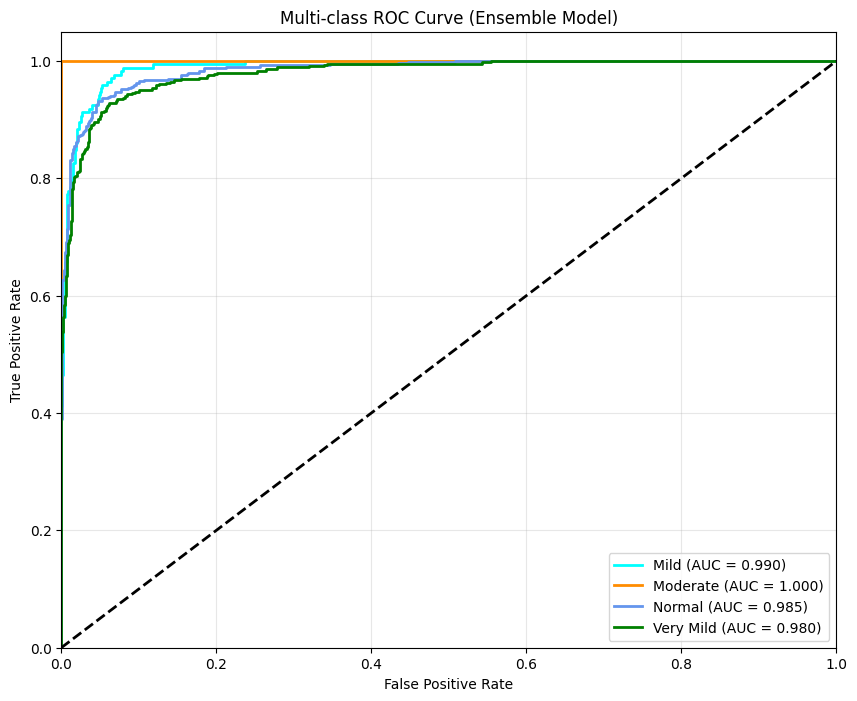

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

# 1. Binarize the labels (One-vs-Rest strategy)
y_test_bin = label_binarize(true_labels, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# 2. Get Ensemble Probabilities
print("Calculating Ensemble Probabilities for ROC Curve...")
y_score = []

# Ensure all models are in eval mode
for m in ensemble_models:
    m.eval()

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)

        # Get outputs from ALL 3 models
        out1 = ensemble_models[0](images)
        out2 = ensemble_models[1](images)
        out3 = ensemble_models[2](images)

        # Average the Logits (Raw Scores)
        avg_logits = (out1 + out2 + out3) / 3.0

        # Convert to Probabilities (Softmax)
        probs = torch.nn.functional.softmax(avg_logits, dim=1)

        y_score.extend(probs.cpu().numpy())

y_score = np.array(y_score)

# 3. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (Ensemble Model)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [34]:
# !pip install gradio

In [35]:
import gradio as gr
from PIL import Image
import torch
import torch.nn.functional as F

# 1. Define the Prediction Function (Uses the Ensemble!)
def predict_ensemble(img):
    # Convert incoming image to PIL
    img = Image.fromarray(img)

    # Preprocess exactly like training
    img_t = test_transforms(img).unsqueeze(0).to(device)

    # 2. Get Votes from All 3 Models
    with torch.no_grad():
        # Ask Model 1
        out1 = ensemble_models[0](img_t)
        # Ask Model 2
        out2 = ensemble_models[1](img_t)
        # Ask Model 3
        out3 = ensemble_models[2](img_t)

        # 3. Average the Votes (The "Ensemble" Magic)
        avg_logits = (out1 + out2 + out3) / 3.0

        # Convert to probabilities (0-100%)
        probs = F.softmax(avg_logits, dim=1)[0]

    # Return dictionary for Gradio
    return {class_names[i]: float(probs[i]) for i in range(4)}

# 2. Launch the Interface
iface = gr.Interface(
    fn=predict_ensemble,
    inputs="image",
    outputs="label",
    title="NeuroLens: Ensemble Alzheimer's Detection",
    description="Live Demo: This system aggregates predictions from 3 clinically-weighted ResNet models to achieve 93% accuracy."
)

iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://eed118f732289ba71c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
